In [5]:
import numpy as np

act = np.load("../data/our_activations/root_19.npy")
act = None

In [3]:
from lczerolens import LczeroModel, LczeroBoard
from pathlib import Path
import torch
from IPython.display import clear_output

def load_lc0():
    path = str(Path(".").resolve().parent / "lc0" / "t79.onnx")
    model = LczeroModel.from_path(path)
    return model

def sample_legal_move(policy_logits: torch.Tensor, board: LczeroBoard) -> int:
    legal_moves: torch.Tensor = board.get_legal_indices()
    print(legal_moves.dtype)
    legal_mask = torch.zeros_like(policy_logits, dtype=torch.bool)
    legal_mask[legal_moves] = True
    legal_logits = policy_logits.masked_fill(~legal_mask, float('-inf'))
    legal_probs = torch.softmax(legal_logits, dim=-1)
    move_index = torch.multinomial(legal_probs, num_samples=1).item()
    return move_index

def play_game(model, depth):
    board = LczeroBoard()

    with torch.no_grad():
        for _ in range(depth):
            if board.is_game_over():
                break

            # Clear the old board and display the new one
            # clear_output(wait=True)
            display(board)

            if board.turn:  # White to move (you)
                while True:
                    try:
                        move_str = input("Your move (in UCI format, e.g., e2e4): ")
                        move = board.parse_uci(move_str)
                    except Exception:
                        continue
                    break
            else:  # Black's move (AI)
                tensor_input = board.to_input_tensor().unsqueeze(0)
                outputs = model(tensor_input)
                move_idx = sample_legal_move(outputs["policy"].squeeze(), board)
                move = board.decode_move(move_idx)

            board.push(move)

model = load_lc0()


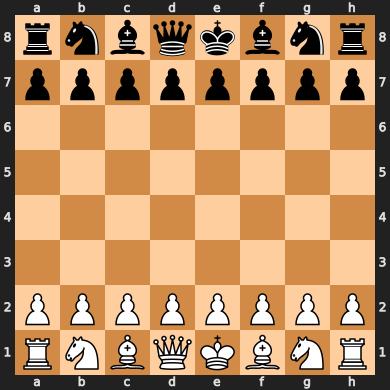

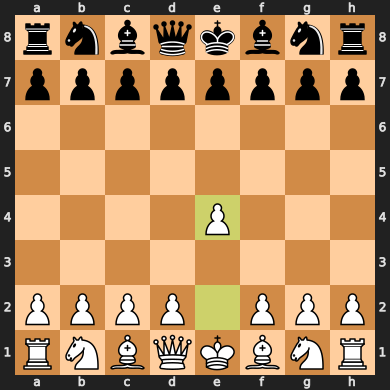

torch.int64


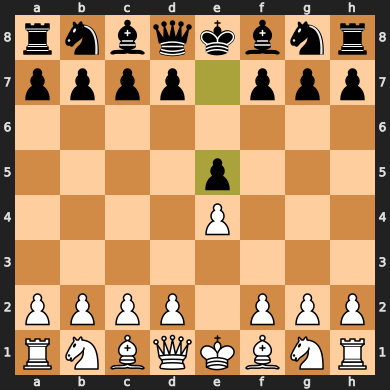

KeyboardInterrupt: Interrupted by user

In [4]:
play_game(model, 200)

In [ ]:
import torch
import importlib
from pathlib import Path
import sys
import numpy as np
from torch.utils.data import DataLoader

sys.path.append("..")
from numpy_loader import chunk_loader
from csae_train import CNNDataset

import cnnsae_simple as cnnsae

experiment_name = "20250317-212631_sparsenowhabrokls10"
exp_folder = Path(".").resolve().parent / "experiments" / experiment_name

import importlib.util

def load_module_from_path(module_name, path):
    spec = importlib.util.spec_from_file_location(module_name, path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module

# cnnsae = load_module_from_path("cnnsae_small", exp_folder / "cnnsae_small.py")

model: torch.nn.Module = cnnsae.CSAE(ls_factor=10)
checkpoint = torch.load(exp_folder / "checkpoint.pt", weights_only=True)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to("cuda")


n_samples = 250

def get_rand_samples(n: int = 250):

    iterator = chunk_loader(Path(".").resolve().parent / "data" / "test_activations")
    chunk = next(iterator)

    inds = np.random.choice(chunk[0].shape[0], n, replace=False)

    return chunk[0][inds, :], chunk[1][inds, :], chunk[2][inds, :]

samples = get_rand_samples(n_samples)
dataset= CNNDataset(*samples)
loader = DataLoader(dataset, n_samples)

optimal, suboptimal = next(iter(loader))
batch_pairs = torch.cat((optimal, suboptimal), dim=0)
batch_pairs = batch_pairs.to("cuda")

encoded, decoded = model(batch_pairs)


lsfactor 10


In [ ]:
(encoded > 0.1).sum() / (decoded.numel())

tensor(0.0013, device='cuda:0')

In [ ]:
import sys
import numpy as np
from pathlib import Path

sys.path.append("..")
from numpy_loader import chunk_loader

def get_rand_samples(n: int = 250):

    iterator = chunk_loader(Path(".").resolve().parent / "data" / "test_activations")
    chunk = next(iterator)

    inds = np.random.choice(chunk[0].shape[0], n, replace=False)

    return chunk[0][inds, :], chunk[1][inds, :], chunk[2][inds, :]

samples = get_rand_samples(300)

In [ ]:
from itertools import combinations
import numpy as np
import tqdm

def pav(ballots: list[set[int]], k: int, candidates: list[int], verbal: bool=False):

    max_score = -float("inf")
    ws = []

    for combination in combinations(candidates, k):
        combination = set(combination)

        score = 0
        for b in ballots:
            intersection = combination.intersection(b)
            score += sum((1 / i) for i in range(1, len(intersection) + 1))

        if verbal:
            print(combination, score)

        if max_score < score:
            max_score = score
            ws = [combination]
        if score == max_score:
            ws.append(combination)


    ws = sorted(ws, key=lambda w: sorted(tuple(w)))

    return ws[0], max_score, len(ws) - 1

results = []
for _ in tqdm.tqdm(range(100_000), total=100_000):

    n_ballots = np.random.randint(3, 10)
    n_candidates = np.random.randint(3, 6)
    candidates = list(range(n_candidates))
    ballots = []
    for _ in range(n_ballots):
        n_chosen = np.random.randint(1, n_candidates + 1)
        ballot = np.random.choice(n_candidates, size=n_chosen, replace=False)
        ballots.append(set(ballot))

    w, _, ties = pav(ballots, 2, candidates)
    w_next, _, ties_next = pav(ballots, 3, candidates)

    if not w.issubset(w_next):
        results.append((ballots, candidates))

def calc(x: tuple[list, list]):
    return len(x[0]) + len(x[1])

results = sorted(results, key=calc)
results[0]

100%|██████████| 100000/100000 [00:14<00:00, 6898.61it/s]


([{1, 2}, {2, 3}, {0, 1, 2}, {0, 2, 3}], [0, 1, 2, 3])

In [ ]:
ballots, candidates = results[0]
print("Ballots", ballots)
print("Candidates", candidates)

print("[k=2]")
print(pav(ballots, 2, candidates, verbal=True))
print("[k=3]")
print(pav(ballots, 3, candidates, verbal=True))

Ballots [{1, 2}, {2, 3}, {0, 1, 2}, {0, 2, 3}]
Candidates [0, 1, 2, 3]
[k=2]
{0, 1} 3.5
{0, 2} 5.0
{0, 3} 3.5
{1, 2} 5.0
{1, 3} 4.0
{2, 3} 5.0
({0, 2}, 5.0, 3)
[k=3]
{0, 1, 2} 5.833333333333333
{0, 1, 3} 5.0
{0, 2, 3} 5.833333333333333
{1, 2, 3} 6.0
({1, 2, 3}, 6.0, 1)


In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor()])
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

n_channels, w, h = 50, 28, 28
n_labels = 10

model = nn.Sequential(
    nn.Conv2d(
        in_channels=1,
        out_channels=n_channels,
        kernel_size=3,
        padding=1
    ),
    nn.LeakyReLU(),
     nn.Conv2d(
        in_channels=n_channels,
        out_channels=n_channels,
        kernel_size=3,
        padding=1
    ),
    nn.LeakyReLU(),
     nn.Conv2d(
        in_channels=n_channels,
        out_channels=n_channels,
        kernel_size=3,
        padding=1
    ),
    nn.LeakyReLU(),
    nn.Flatten(),
    nn.Linear(
        n_channels * w * h,
        n_labels
    ),
    nn.Softmax(dim=1)
)

model = model.to("cuda")
criterion = nn.CrossEntropyLoss()
batch_size = 400
adam = torch.optim.AdamW(model.parameters())
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

for _ in range(5):
    for images, labels in tqdm.tqdm(train_loader, total=len(train_loader)):

        images = images.to("cuda")
        labels = labels.to("cuda")
        labels_hat_dist = model(images)
        adam.zero_grad()
        loss = criterion(labels_hat_dist, labels)
        loss.backward()
        adam.step()

    print(loss)


100%|██████████| 150/150 [00:05<00:00, 28.66it/s]


tensor(1.6204, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 150/150 [00:05<00:00, 28.16it/s]


tensor(1.4925, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 150/150 [00:05<00:00, 29.68it/s]


tensor(1.4939, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 150/150 [00:04<00:00, 30.95it/s]


tensor(1.4742, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 150/150 [00:04<00:00, 30.74it/s]


tensor(1.4735, device='cuda:0', grad_fn=<NllLossBackward0>)
Original loss 1.4672470092773438
Adv loss 1.4710232019424438


In [ ]:
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True)
images, labels = next(iter(test_loader))
images = images.to("cuda")
labels = labels.to("cuda")

# Inside train loop
images.requires_grad = True
labels_hat_dist = model(images)
loss = criterion(labels_hat_dist, labels)
loss.backward()

print("Original loss", loss.item())


step = images.grad.sign()
perturbed_image = images + 0.2*step
perturbed_image = torch.clamp(perturbed_image, 0, 1)

labels_hat_dist = model(perturbed_image)
loss = criterion(labels_hat_dist, labels)
print("Adv loss", loss.item())

Original loss 1.4798343181610107
Adv loss 2.17287278175354


In [ ]:
np.mean(np.square(samples[1] - np.random.random(samples[1].shape)))

0.6319482885943021

In [ ]:
encoded_opt, encoded_sub = encoded.chunk(2, dim=0)
c_f_opt, d_f_opt = encoded_opt.chunk(2, dim=1)
c_f_sub, d_f_sub = encoded_sub.chunk(2, dim=1)

In [ ]:
(d_f_opt - d_f_sub).max()

tensor(0.2517, device='cuda:0', grad_fn=<MaxBackward1>)

In [ ]:
(encoded > 0.1).sum() / decoded.numel()

tensor(0.1487, device='cuda:0')

In [ ]:
import numpy as np
n_auxilary_cnns = 3
in_channels = 256
ls_channels = in_channels * 10
print(ls_channels)

t = np.linspace(0, 1, n_auxilary_cnns + 1, endpoint=False)
t = t ** 2
t
c = in_channels + (ls_channels - in_channels) * t
c

2560


array([ 256.,  400.,  832., 1552.])

In [ ]:
import sys

sys.path.append("..")

from numpy_loader import chunk_loader
from pathlib import Path

iterator = chunk_loader(Path(".").resolve().parent / "data" / "train_activations")
one = next(iterator)

In [9]:
import numpy as np

act = np.load("../data/our_activations/root_19.npy")

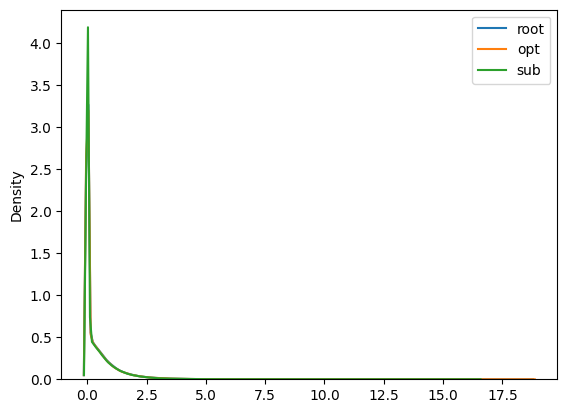

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, ax = plt.subplots()

sns.kdeplot(one[0][:100, :].flatten(), label="root")
sns.kdeplot(one[1][:100, :].flatten(), label="opt")
sns.kdeplot(one[2][:100, :].flatten(), label="sub")

ax.legend()

plt.show()

In [ ]:
d = one[0] - np.random.random(one[0].shape)
np.mean(np.square(d))

0.6644487668682022

In [11]:
(x > 0.1).sum()

2874

In [4]:
n = 50 * 200 * 10 * 192 * 8 * 8
(n * 2) / 1_000_000

2457.6

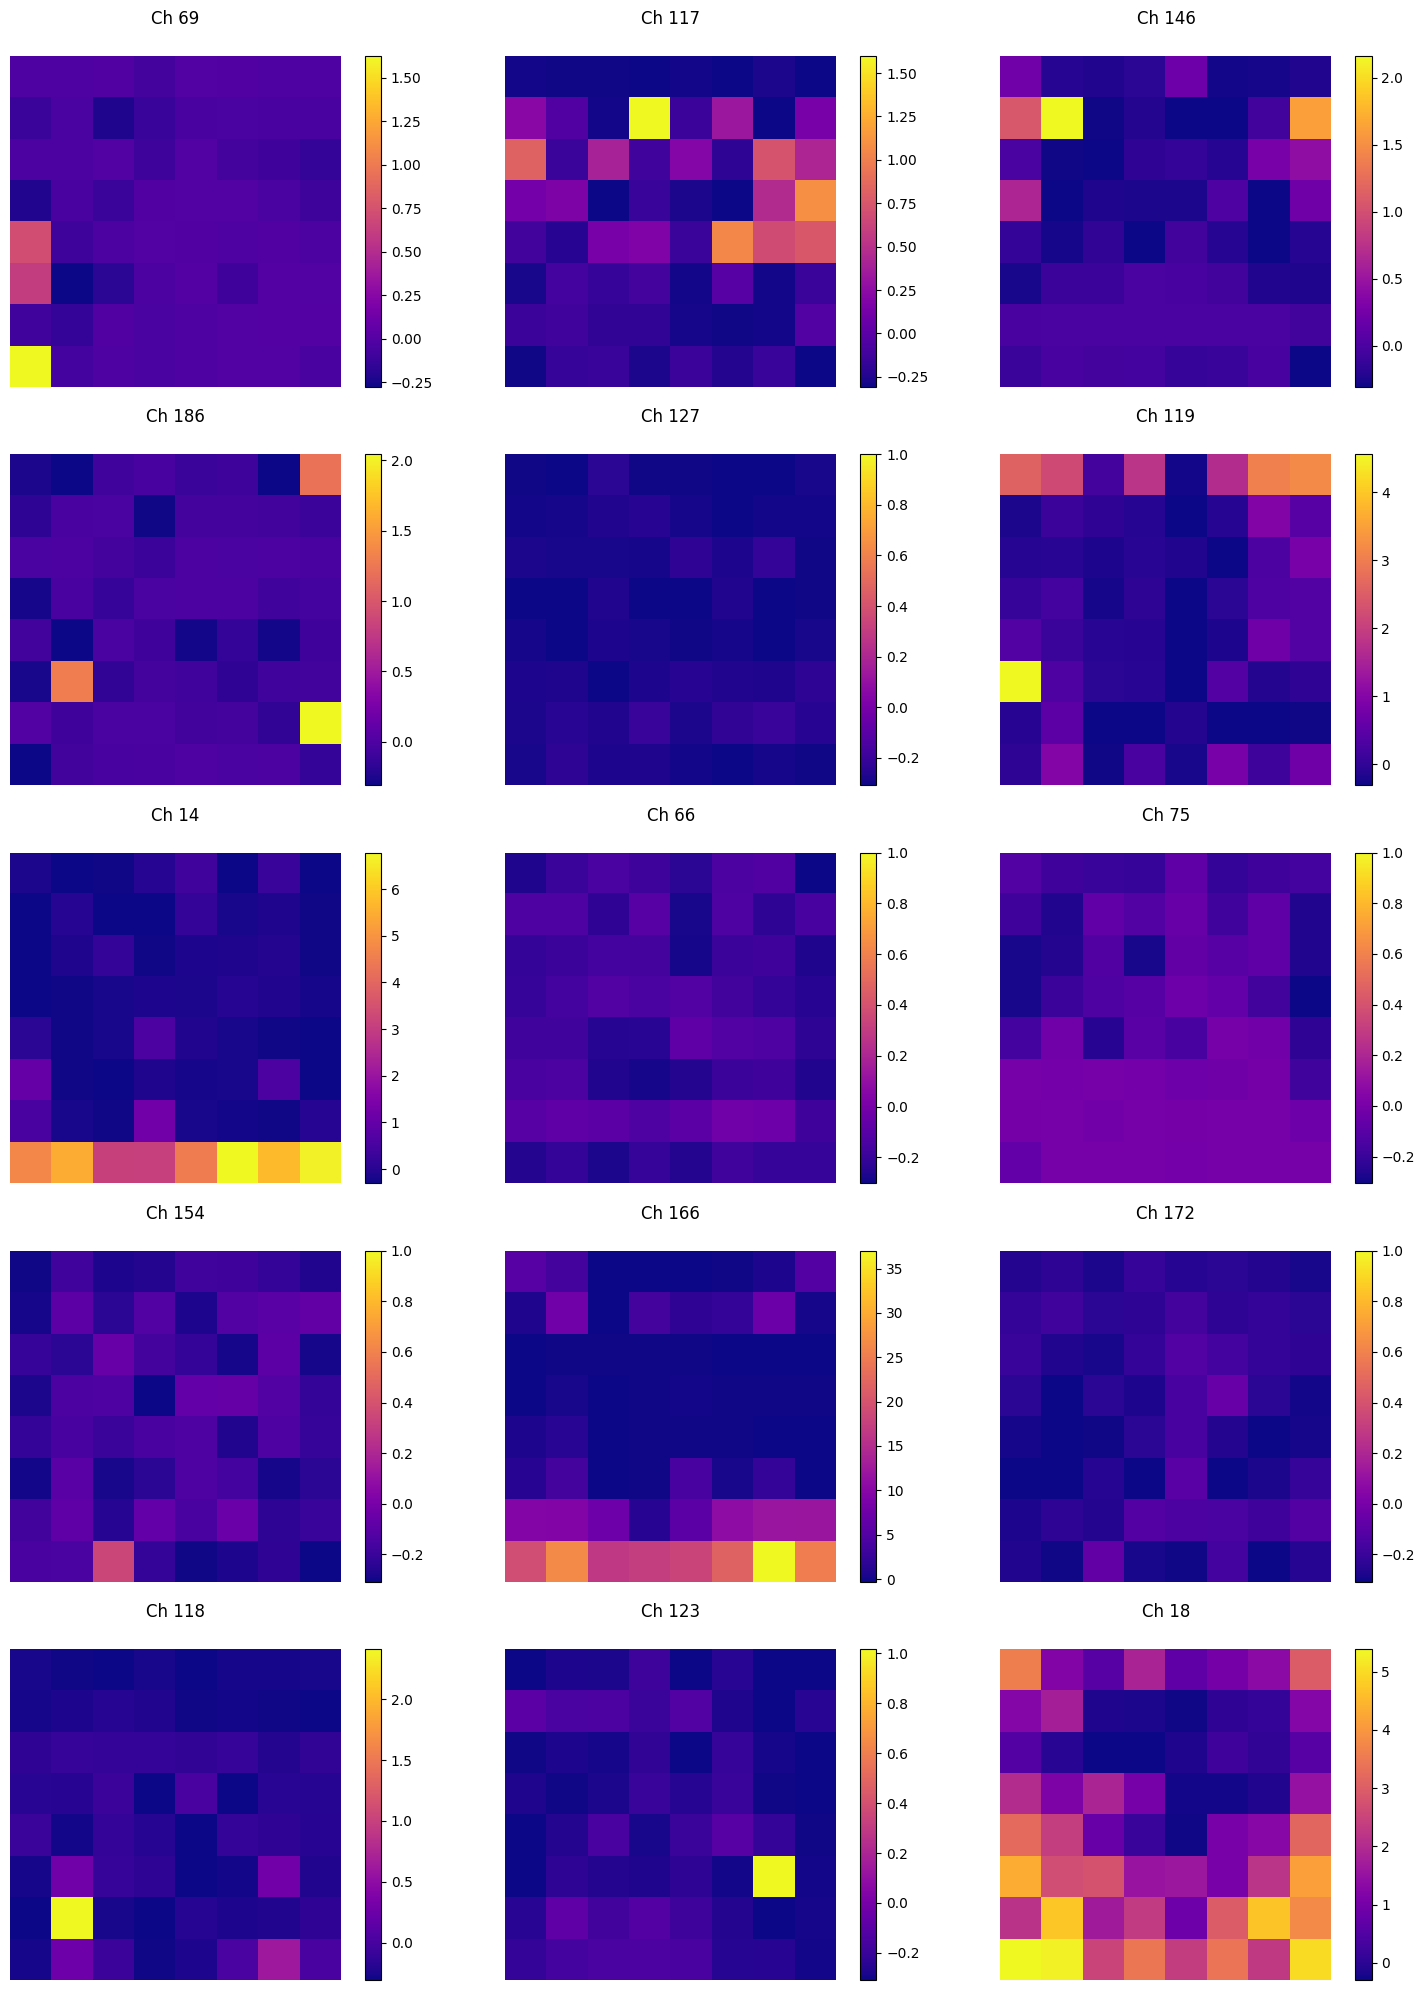

In [15]:
from matplotlib import pyplot as plt

activation_shape = (192, 8, 8)

example = act[2]

# Randomly select 10×3 = 30 channel indices
indices = np.random.choice(activation_shape[0], 15, replace=False)

fig, axes = plt.subplots(5, 3, figsize=(15, 20))

for ax, idx in zip(axes.ravel(), indices):

    amax = max(np.max(example[idx]), 1.0)
    mappable = ax.matshow(example[idx], cmap="plasma", vmax=amax)
    ax.set_title(f"Ch {idx}")
    ax.axis("off")

    fig.colorbar(mappable)

fig.tight_layout()
plt.show()

In [ ]:
(one[0] > 5).sum() / one[0].size

0.0026948974609375

In [ ]:
import pandas as pd

pd.Series(one[0].flatten(), dtype=np.float64).describe()

count    8.192000e+07
mean     4.061816e-01
std      7.565659e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      5.507812e-01
max      2.170312e+01
dtype: float64

In [ ]:
pd.Series(one[1].flatten(), dtype=np.float64).describe()

count    8.192000e+07
mean     3.966775e-01
std      7.446332e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      5.346680e-01
max      2.589062e+01
dtype: float64

In [ ]:
pd.Series(one[2].flatten(), dtype=np.float64).describe()

count    8.192000e+07
mean     3.883239e-01
std      7.318415e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      5.224609e-01
max      2.762500e+01
dtype: float64

In [ ]:
4 * 64

256

In [ ]:
import pandas as pd

df = pd.read_excel("./pice2.xlsx")

In [ ]:
df.columns[0]

'2. How old are you?'

In [ ]:
df = pd.read_excel("./pice2.xlsx")
df = df.rename(columns={
    df.columns[0]: "free_age",
    df.columns[1]: "free_gender",
    df.columns[2]: "free_live",
    df.columns[3]: "free_language",
    df.columns[4]: "speak_to",
    df.columns[5]: "language_identity",
    df.columns[6]: "free_country"
})

df

,free_age,free_gender,free_live,free_language,speak_to,language_identity,free_country
0,29,Non binary,"Columbia, SC USA; 0-4, Carbondale, IL USA; 5-1...",English- learned from birth because American m...,English- most of my friends and family German-...,German and English are tied. English because i...,I’m German/American. Ich bin Berliner. I’m fro...
1,20,Male,"Birth-16: Carbondale, IL, USA (+ two one year ...",English - learned from birth in the USA and my...,"English: Family, friends, anyone close to me r...","English, because I speak it the most and use i...","I was recently asked where I consider ""home"", ..."
2,27,Male,"Birth-21, Northwest Germany; 21-22 Chiang Mai ...",German - learned from birth because it was spo...,"English - with most friends and some family, w...",I identify more with German than English but u...,"I identify as German, though I prefer not to d..."
3,19,Female,Birth-2 (France) -> Tanzania: 2-12 -> The Hagu...,English- Grew up speaking it & went to British...,"English: family and friends, French: Family an...",I speak English the most because of the enviro...,I am from Senegal. I don't feel any ties to Fr...
4,24,male,"Birth - 19, Rome, ITA; 19-20, Ommen, NL; 20-24...",Italian - learned from birth because it was sp...,Italian -- Family and friends\nEnglish -- frie...,I still identify with Italian language because...,I would say that I was born in Italy and lived...
...,...,...,...,...,...,...,...
806,51,female,"0-18 Dokkum, NL, 18-19, Parijs, FR, 19-35 Utre...","Dutch- learned from birth, English- learned in...","Dutch- friends and family, English- at work, f...",With Dutch because i speak this language from ...,I am from the Netherlands
807,51,male,"0-19 Leiden, NL, 19-35 Utrecht, NL, 35-now Ame...",Dutch- learned from birth because i live in th...,"Dutch- Friends and family, English- sometimes ...",Dutch- because i learned it from birth,i am from the Netherlands
808,67,female,"suchań, stargard county, western pomerania, po...","polish - first, native language, standard, the...",polish - everyone,"polish, because this is the only language I am...","my hometown, as it's a place i know the best, ..."
809,43,male,"suchań, poland, then a few months in malaga sp...","polish - first, native language, standard",polish - everyone,polish - the only language i speak and the onl...,"my hometown, and my region, stargard county; p..."


C:\Users\viktor\AppData\Local\Temp\ipykernel_43416\2996158222.py:18: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  rotated_points = np.random.multivariate_normal(mean=centers[i], cov=cov_matrix @ rotation_matrix, size=num_points_per_cluster[i])


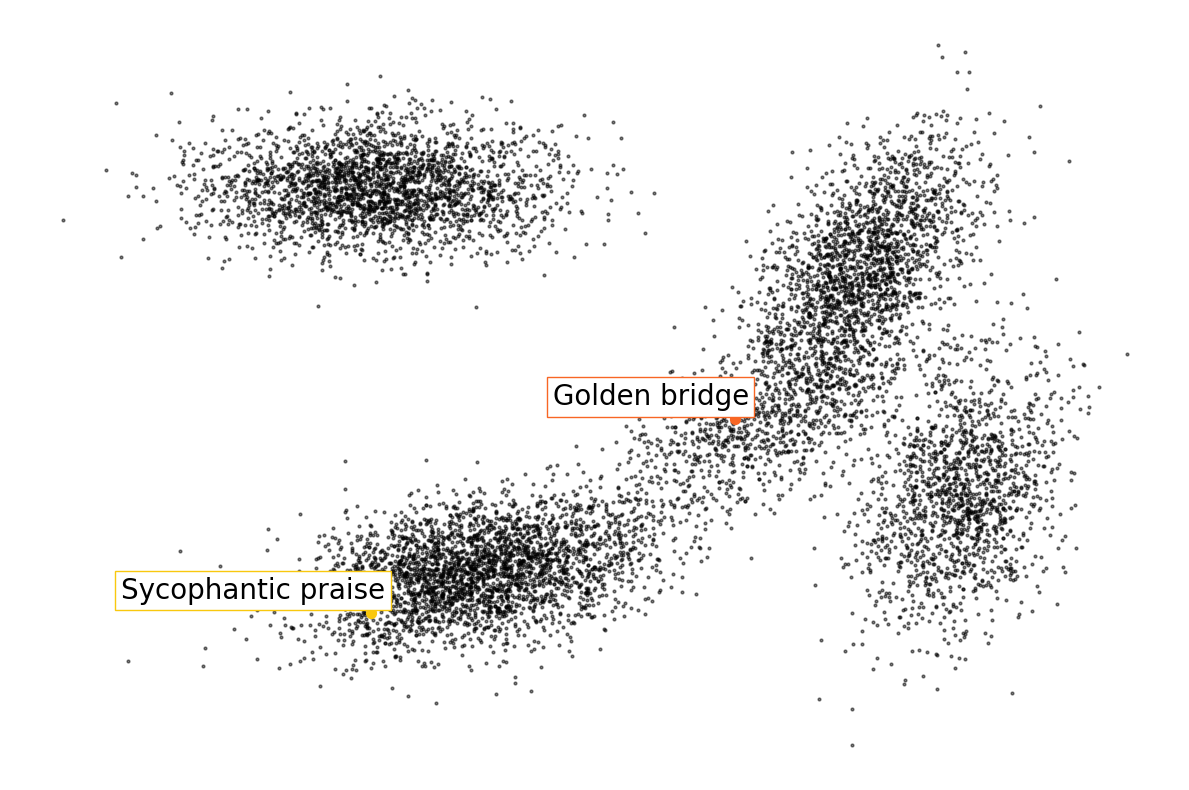

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate clustered scatter points
num_clusters = 5
num_points_per_cluster = [3000, 2000, 2500, 1500, 1000]  # Different densities
centers = [(-2, -2), (2, 2), (-3, 3), (3, -1), (1, 0)]  # Unevenly spaced centers
angles = [30, -20, 45, -30, 10]  # Tilt angles for clusters

x = []
y = []
for i in range(num_clusters):
    theta = np.radians(angles[i])
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])

    cov_matrix = np.array([[0.5, 0.3], [0.3, 0.5]])  # Covariance for tilting effect
    rotated_points = np.random.multivariate_normal(mean=centers[i], cov=cov_matrix @ rotation_matrix, size=num_points_per_cluster[i])
    x.extend(rotated_points[:, 0])
    y.extend(rotated_points[:, 1])

x = np.array(x)
y = np.array(y)

# Choose two points to highlight
highlight_indices = np.random.choice(len(x), 2, replace=False)
highlight_x = x[highlight_indices]
highlight_y = y[highlight_indices]
highlight_labels = ["Golden bridge", "Sycophantic praise"]
highlight_colors = ["#F86624", "#F9C80E"]  # Modern color choices

# Create figure
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x, y, s=4, color='black', alpha=0.5)
ax.scatter(highlight_x[0], highlight_y[0], s=50, color=highlight_colors[0], alpha=1)
ax.scatter(highlight_x[1], highlight_y[1], s=50, color=highlight_colors[1], alpha=1)

# Annotate highlighted points
for i in range(2):
    ax.annotate(highlight_labels[i], (highlight_x[i], highlight_y[i]),
                textcoords="offset points", xytext=(10,10), ha='right', fontsize=20,
                bbox=dict(edgecolor=highlight_colors[i], facecolor="white"))

# Remove axes for aesthetic
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

fig.tight_layout()

fig.savefig("./introslide.png", dpi=100)
plt.show()


In [ ]:

def age_map(v):

    age_mapper = {
        "01-12-1972  52 jaar": 52,
        "19 years old, almost 20.": 19,
        "21 years old": 21,
        "I am 18 years old": 18,
        "22 years old": 22,
        "18, almost 19": 18,
        "57 years": 57,
        "I'm 23 years old ": 23,
        "IAm 59": 59,
        "50 years old": 50,
        "48 years old": 48,
        "56 years old": 56,
        "Too old (52 y)": 52,
        "18 years old ": 18,
        "48 years old. ": 48,
        "20 years": 20,
        "20 years old": 20,
        "I m 58 years old": 58,
        "I am 20 years old": 20,
        2024: float("nan"),
        "56 jahre": 56,
        "19 y.o.": 19,
        "20+24": 44,
        "19 years old": 19,

    }

    if v in age_mapper:
        return age_mapper[v]

    else:
        return v

In [ ]:
df["age"] = df["free_age"].apply(age_map)
df["age"] = pd.to_numeric(df["age"], errors="coerce")

In [ ]:
from openai import OpenAI
from tqdm import tqdm

def gpt_parser(prompt, client: OpenAI):

    def aply_callback(v):

        msg = prompt.format(v)
        completion = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {
                    "role": "user",
                    "content": msg
                }
            ]
        )

        return completion.choices[0].message.content

    return aply_callback


def start_prompt(column: pd.Series, apply_callback):

    parsed = []
    for v in tqdm(column, total=column.size):
        parsed.append(apply_callback(v))

    return parsed

In [ ]:
import asyncio
from tqdm import tqdm
import pandas as pd
from openai import AsyncClient

async def async_aply_callback(v, prompt, client: AsyncClient):
    msg = prompt.format(v)
    completion = await client.chat.completions.create(
        model="gpt-4",
        messages=[
            {
                "role": "user",
                "content": msg
            }
        ]
    )
    return completion.choices[0].message.content

async def process_batch(batch, prompt, client):
    tasks = [async_aply_callback(v, prompt, client) for v in batch]
    return await asyncio.gather(*tasks)

async def async_gpt_parser(column, prompt, client, num_workers=5):
    parsed = []

    column = column.tolist()
    # Split data into chunks for each worker
    batches = [column[i:i+num_workers] for i in range(0, len(column), num_workers)]
    for batch in tqdm(batches, total=len(batches)):
        results = await process_batch(batch, prompt, client)
        parsed.extend(results)

    return parsed



In [ ]:
language_prompt = """
You will need to parse human form responses.
People were asked what languages do they speak.
Extract their responses in a structured way.
Extract each language in a comma separated list (for example "english, german, dutch")
I don't care about regional dialects, only put the official languages to the list.
Do not abbreviate any language name.
Do not answer any other text!
If you cannot recognize any langauge just output "none".

The form response:
{}
"""

languaged_parsed = await async_gpt_parser(df["free_language"], language_prompt, aclient, num_workers=30)

100%|██████████| 28/28 [00:57<00:00,  2.06s/it]


In [ ]:
languaged_parsed

811

In [ ]:
country_prompt = """
You will need to parse human form responses.
People were asked what place do they identify with.
Extract their responses in a structured way.
Extract each place/region/country in a comma separated list (for example "bratislava, england, europe")
Do not abbreviate any other place name.
Only put eu/europe on the list if the response explicitely mentions europe (countries in eu do not count)
Do not answer any other text!
If you cannot recognize any place just output "none".

The form response:
{}
"""


country_parsed = await async_gpt_parser(df["free_country"], country_prompt, aclient, num_workers=30)


100%|██████████| 28/28 [00:58<00:00,  2.08s/it]


In [ ]:
df["language"] = languaged_parsed
df["country"] = country_parsed

In [ ]:
lang_set = set()

language_groups = []

language_mapper = {
    "lower german": "german",
    "low german": "german",
    "fries": "friesian",
    "germen": "german",
    "engels": "english"
}

for lang in languaged_parsed:
    langs = lang.split(", ")

    person_set = set()

    for l in langs:
        language = l.lower().strip()
        language = language_mapper.get(language, language)

        person_set.add(language)
        lang_set.add(language)

    group = None
    if len(person_set) == 1:
        group = "mono"
    elif (len(person_set) == 2) and ("english" in person_set):
        group = "bi_e"
    elif (len(person_set) == 2) and ("english" not in person_set):
        group = "rest"
    elif (len(person_set) >= 3):
        group = "rest"
    else:
        print("error", person_set)

    language_groups.append(group)


In [ ]:
country_set = list()

country_groups = []

country_mapper = {
    "eastern europe": "eu",
    "europe": "eu",
    "western europe": "eu",
    "european union": "eu",
    "european": "eu"
}

for countries in country_parsed:
    list_countries = countries.split(", ")

    person_set = set()

    for c in list_countries:
        country = c.lower().strip()
        country = country_mapper.get(country, country)

        person_set.add(country)
        country_set.append(country)

    group = None

    if (len(person_set) == 1) and ("eu" in person_set):
        group = "eu"
    elif (len(person_set) > 1) and ("eu" in person_set):
        group = "eu+"
    else:
        group = "rest"

    country_groups.append(group)

temp = pd.Series(list(country_set))
temp = temp[temp.str.contains("eu")]

with pd.option_context("display.max_colwidth", None):
    display(temp.value_counts())


eu                   39
leeuwarden            7
neubeuern             1
son en breugel        1
la reunion island     1
reunion               1
Name: count, dtype: int64

In [ ]:
df["country_group"]= country_groups
df["language_group"]= language_groups

In [ ]:
df["language_group"].value_counts()

language_group
rest    674
bi_e    109
mono     28
Name: count, dtype: int64

In [ ]:
df["country_group"].value_counts()

country_group
rest    775
eu+      32
eu        4
Name: count, dtype: int64

In [ ]:
df["age"].describe()

count    808.000000
mean      32.340347
std       17.329141
min       11.000000
25%       19.000000
50%       22.000000
75%       49.000000
max       87.000000
Name: age, dtype: float64

In [ ]:
stops = [
    (18, 29),
    (30, 49),
    (50, 100)
]

age_groups = []

age_names = ["18-29", "30-49", "50+"]
for age in df["age"]:
    ga = False
    for i_group, (mina, maxa) in enumerate(stops):
        if mina <= age <= maxa:
            ga = True
            age_groups.append(age_names[i_group])
            break

    if not ga:
        age_groups.append(float("nan"))

df["age_group"] = age_groups
df["age_group"].value_counts()

age_group
18-29    490
50+      201
30-49     93
Name: count, dtype: int64

In [ ]:
print(str(pd.crosstab(df["age_group"], df["language_group"])))

language_group  bi_e  mono  rest
age_group                       
18-29             67     9   414
30-49             17     6    70
50+               23    11   167


In [ ]:
print(str(pd.crosstab(df["age_group"], df["country_group"])))

country_group  eu  eu+  rest
age_group                   
18-29           2   19   469
30-49           0    4    89
50+             2    9   190


In [ ]:
with pd.option_context("display.max_colwidth", None):
    display(df[df["age"] >= 50][["free_language", "language"]].sample(10))

,free_language,language
802,"English - mother tongue, learned from birth; French and German - learned at school 12-18 and university 18-21","english, french, german"
780,"Bulgarian - learned from birth because it was spoken at home and because I have living in Bulgaria; English, I learned it between the ages of 6 and 8 in private lessons, and then from the ages of 13 to 24 in school and in private lessons; Russian, I learned it in school between the ages of 9 and 18.","bulgarian, english, russian"
642,"Dutch - learned from birth, I was born here. Twents - dialect from the region where I'm from. English - learned it for a year in school, I'm not very good.","dutch, english"
635,French - mother language / English from school age 10-18 / Spanish school from age 14-18 / kreol - reunion island dialect learned from the street from age 0-18,"french, english, spanish"
392,"Dutch, learned from birth because it was spoken at home - Bolswarders: learned from my peers when I was about 10 yrs - English: learned at school from 12-18, at University 18-24 and during my one year stay in Canada ages 21-22, German: learned at school from 12-18, French: learned at school from 12-18, Frisian: taught at school 6-12 but did not speak it. When I moved back to Wommels, Friesland I learned to speak it by listening to other people and practicing","dutch, english, german, french, frisian"
672,"romanian - learned from birth, italian - at 40 worked in italy for quite some time, german - learn it at 47 because i started working in austria, and now university","romanian, italian, german"
137,"Frisian birth - today. Dutch 3y- today, English 12-today, learned at school and hbo teacher course, German: 12-17 havo, French 12-17 havo","Frisian, Dutch, English, German, French"
51,"Reional language since I was born, common Dutch from basic school onward, german, french and English since my high school time.","dutch, german, french, english"
517,"Dutch- at home en lived there all my life, German-English-French learned in school ages 12-20","dutch, german, english, french"
807,"Dutch- learned from birth because i live in the Netherlands, English- learned at high school, French- learned at high school","dutch, english, french"


In [ ]:
df.to_excel("./output.xlsx", index=False)

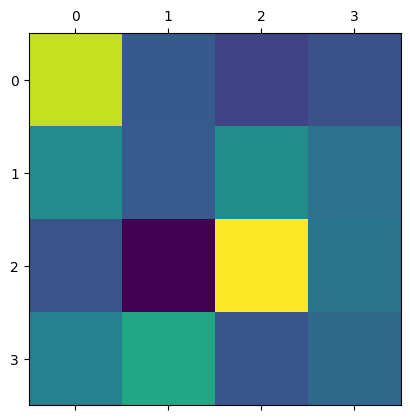

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

outgoing = 0
incoming = 1

def generate_W(n: int):

    W = np.random.random((n, n))
    w_sum = np.sum(W, axis=1, keepdims=True)
    return W / w_sum


W = generate_W(4)

plt.matshow(W)

In [ ]:
def step(P: np.ndarray, W: np.ndarray):

    # W shape (n, n)
    # P shape (n,)

    if P.ndim == 2:
        P = np.squeeze(P)


    new_P = np.zeros_like(P)
    for i_classifier, p_me in enumerate(P):
        inc = W[:, i_classifier]
        out = W[i_classifier, :]

        new_P[i_classifier] = np.sum(inc * P - out * p_me)

    return new_P[:, np.newaxis]

def step_m(P: np.ndarray, W: np.ndarray):
    row_sums = np.sum(W, axis=1)
    D = np.diag(row_sums)
    return (W.T - D) @ P

P0 = np.ones((W.shape[0], 1))
step(step(P0, W), W)

array([[-0.17809712],
       [ 0.1825414 ],
       [-0.12659025],
       [ 0.12214597]])

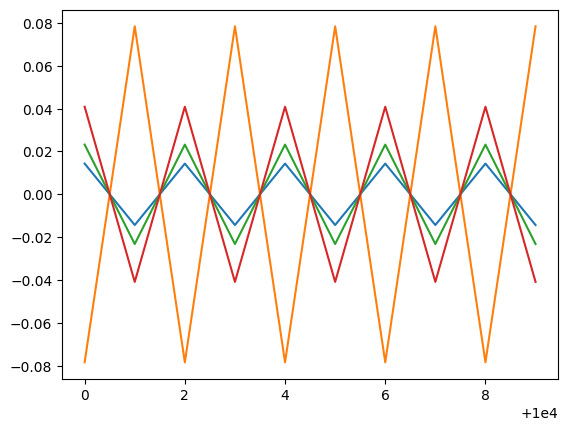

In [ ]:

def set_spectral_radius_one(A: np.ndarray) -> np.ndarray:
    eigenvalues = np.linalg.eigvals(A)
    rho = np.max(np.abs(eigenvalues))
    if rho == 0:
        return A
    return A / rho

def progress(P: np.ndarray, W: np.ndarray, steps: int):
    row_sums = np.sum(W, axis=1)
    D = np.diag(row_sums)
    A = (W.T - D)
    A = set_spectral_radius_one(A)
    return np.linalg.matrix_power(A, steps) @ P

steps = list(range(10_000, 10_010))

Ps = []
for s in steps:
    Ps.append(progress(P0, W, s))

Ps = np.array(Ps)
for i in range(Ps.shape[1]):
    plt.plot(steps, Ps[:, i])

In [ ]:
U, S, V = np.linalg.svd((W.T - D))
S

array([1.50111564e+00, 1.06294752e+00, 7.09975957e-01, 1.07645610e-16])

In [ ]:
W = np.array([
    [0.5, 0.5, 0.0],
    [0.0, 0.5, 0.5],
    [0.5, 0.0, 0.5]
])



In [ ]:
2 ** 3

8

In [ ]:
np.sum(1 / (2 ** np.arange(1, 10)))

0.998046875

In [ ]:
1/2 + 1/4 + 1/8 + 1/16 + 1/32 + 1/64

0.984375